# RAYLEIGH RITZ METHOD

Shape function $\phi(x)$ is taken as

- For $i = 1, \phi(\xi) = 1 $
- For $i = 2, \phi(\xi) = \xi $
- For $i = 3, \phi(\xi) = \xi^2 $
- For $i >=4, \phi(\xi) = cos((i-3)\pi \xi)$

where $\xi = \frac{x}{L}$, is the non-dimensional coordinate


Mass Matrix is given by:

$M(i,j) = \frac{\rho A L}{2} \int_0^1 \phi_i \phi_j \,d\xi$




Stiffness Matrix is given by :

$K(i,j) = \frac{E I}{L^3} \int_0^1 \phi''_i \phi''_j \,d\xi$


In [2]:
import sympy as sp
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# declaring values
LENGTH = 5                          # in m
BREADTH = 0.5                       # in m
HEIGHT = 0.5                        # in m
MOD_ELAS = 7E10                     # modulus of elasticity in N/m^4
DENSITY = 2700                      # in Kg/m^3
    
AREA = BREADTH*HEIGHT               # in m^2
AREA_MI = (BREADTH*(HEIGHT**3))/12    # area moment of inertia in m^4
N = 10
i, j, xi = sp.symbols('i j ξ')

In [5]:
#shape function for i = 1
Shape_Fun_1 = 1

#shape function for i = 2
Shape_Fun_2 = xi

#shape function for i = 3
Shape_Fun_3 = xi**2

#shape function for i >= 4
Shape_Fun_4 = sp.cos((i - 3)*np.pi*xi)

#First Derivative of shape function for i = 1
D_Shape_Fun_1 = sp.diff(Shape_Fun_1, xi)

#First Derivative of shape function for i = 2
D_Shape_Fun_2 = sp.diff(Shape_Fun_2, xi)

#First Derivative of shape function for i = 3
D_Shape_Fun_3 = sp.diff(Shape_Fun_3, xi)

#First Derivative of shape function for i >= 4
D_Shape_Fun_4 = sp.diff(Shape_Fun_4, xi)

#Double derivative of shape function for i = 1
DD_Shape_Fun_1 = sp.diff(Shape_Fun_1, xi, 2)

#Double derivative of shape function for i = 2
DD_Shape_Fun_2 = sp.diff(Shape_Fun_2, xi, 2)

#Double derivative of shape function for i = 3
DD_Shape_Fun_3 = sp.diff(Shape_Fun_3, xi, 2)

#Double derivative of shape function for i >= 4
DD_Shape_Fun_4 = sp.diff(Shape_Fun_4, xi, 2)

SHAPE_FUNCTIONS = {
    1:Shape_Fun_1,
    2:Shape_Fun_2,
    3:Shape_Fun_3,
    "else":Shape_Fun_4
}

D_SHAPE_FUNCTIONS = {
    1:D_Shape_Fun_1,
    2:D_Shape_Fun_2,
    3:D_Shape_Fun_3,
    "else":D_Shape_Fun_4
}

DD_SHAPE_FUNCTIONS = {
    1:DD_Shape_Fun_1,
    2:DD_Shape_Fun_2,
    3:DD_Shape_Fun_3,
    "else":DD_Shape_Fun_4
}

display(SHAPE_FUNCTIONS)
display(D_SHAPE_FUNCTIONS)
display(DD_SHAPE_FUNCTIONS)

{1: 1, 2: ξ, 3: ξ**2, 'else': cos(ξ*(3.14159265358979*i - 9.42477796076938))}

{1: 0,
 2: 1,
 3: 2*ξ,
 'else': -(3.14159265358979*i - 9.42477796076938)*sin(ξ*(3.14159265358979*i - 9.42477796076938))}

{1: 0,
 2: 0,
 3: 2,
 'else': -88.8264396098042*(0.333333333333333*i - 1)**2*cos(ξ*(3.14159265358979*i - 9.42477796076938))}

In [6]:
def make_csv(data, name):
    df = pd.DataFrame(data)
    name += '.csv'  
    df.to_csv(name, index = None, header = None)

def make_mass_matrix(n):
    M = np.zeros((n, n), dtype = 'float')
    M[0][0] = 1
    M[0][1] = 0.5
    M[1][0] = 0.5
    M[0][2] = 1/3
    M[1][1] = 1/3
    M[2][0] = 1/3
    M[1][2] = 0.25
    M[2][1] = 0.25
    M[2][2] = 0.2
    for x in range(3, n):
        M[1][x] = (np.cos((x - 2)*np.pi) - 1)/(((x - 2)**2)*np.pi**2)
        M[x][1] = (np.cos((x - 2)*np.pi) - 1)/(((x - 2)**2)*np.pi**2)
        M[2][x] = 2*np.cos((x - 2)*np.pi)/(((x - 2)**2)*np.pi**2)
        M[x][2] = 2*np.cos((x - 2)*np.pi)/(((x - 2)**2)*np.pi**2)
        M[x][x] = 0.5
    return M


def make_stiffness_matrix(n):
    K = np.zeros((n,n), dtype = 'float')
    K[2][2] = 4

    for x in range(3, n):
        K[x][x] = 0.5*(np.pi**4)*(x - 2)**4

    return K


def make_translational_constraint_x_0(n):
    translational_constraint_x_0 = np.ones((n,n))
    translational_constraint_x_0[:, 1:3] =  0
    translational_constraint_x_0[1:3, :] =  0
    return translational_constraint_x_0


def make_rotational_constraint_x_0(n):
    rotational_constraint_x_0 = np.zeros((n,n))
    rotational_constraint_x_0[1][1] = 1
    return rotational_constraint_x_0


def make_translational_constraint_x_L(n):
    translational_constraint_x_L = np.ones((n, n), dtype = 'int')
    for x in range(3, n):
        translational_constraint_x_L[0][x] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[x][0] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[1][x] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[x][1] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[2][x] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[x][2] = np.cos((x - 2)*np.pi)
    for x in range(3, n):
        for y in range(3, n):
            translational_constraint_x_L[x][y] = np.cos((x - 2)*np.pi)*np.cos((y - 2)*np.pi)
    return translational_constraint_x_L


def make_rotational_constraint_x_L(n):
    rotational_constraint_x_L = np.zeros((n,n))
    rotational_constraint_x_L[1][1] = 1
    rotational_constraint_x_L[1][2] = 2
    rotational_constraint_x_L[2][1] = 2
    rotational_constraint_x_L[2][2] = 4
    return rotational_constraint_x_L



def make_penalty_matrix(t_c_0, r_c_0, t_c_L, r_c_L, k_0, k_r_0, k_L, k_r_L):
    n = len(t_c_0)
    penality_matrix = np.zeros((n,n))
    for x in range(n):
        for y in range(n):
            penality_matrix[x][y] = k_0*t_c_0[x][y] + k_r_0*r_c_0[x][y] + k_L*t_c_L[x][y] + k_r_L*r_c_L[x][y]
    
    return penality_matrix

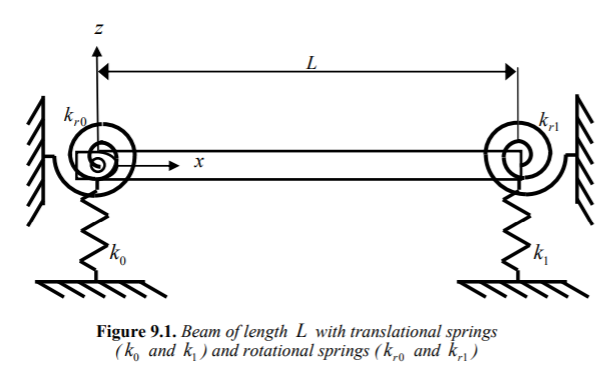

In [7]:
K_Coeff = MOD_ELAS*AREA_MI/LENGTH**3
M_Coeff = DENSITY*AREA*LENGTH

# Modeshapes and Convergence of Fixed - Free beam

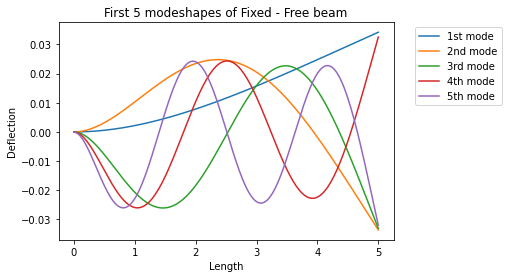

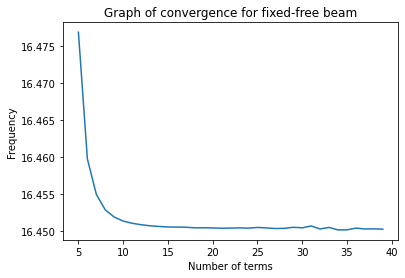

In [15]:
# Fixed Free
N = 10

# non dimensionalised stiffness matrix
K_MATRIX = make_stiffness_matrix(N)
# make_csv(K_MATRIX, 'K')

# non dimensionalised mass matrix
M_MATRIX = make_mass_matrix(N)
# make_csv(M_MATRIX, 'M')

cM = 0       # Inertial Penalty Parameter
cK = 1       # Stiffness type Penalty Parameter


PenaltyParameter = 1000000
K0 = PenaltyParameter * 1     # Translation at x = 0
KR0 = PenaltyParameter * 1    # Rotation at x = 0
KL = PenaltyParameter * 0     # Translation at x = L
KRL = PenaltyParameter * 0    # Rotation at x = L

TRANSLATIONAL_CONSTRAINT_0 = make_translational_constraint_x_0(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_0, "T_C_0")

ROTATIONAL_CONSTRAINT_0 = make_rotational_constraint_x_0(N)
# make_csv(ROTATIONAL_CONSTRAINT_0, "R_C_0")

TRANSLATIONAL_CONSTRAINT_L = make_translational_constraint_x_L(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_L, "T_C_L")

ROTATIONAL_CONSTRAINT_L = make_rotational_constraint_x_L(N)
# make_csv(ROTATIONAL_CONSTRAINT_L, "R_C_L")



# fnding the penalty matrix of the beam
PENALTY_MATRIX = make_penalty_matrix(TRANSLATIONAL_CONSTRAINT_0, ROTATIONAL_CONSTRAINT_0, TRANSLATIONAL_CONSTRAINT_L,  ROTATIONAL_CONSTRAINT_L, K0, KR0, KL, KRL)
# make_csv(PENALTY_MATRIX, "P_M")

K = K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX)
M = M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX)


C = np.zeros((2*N, 2*N))
A = np.vstack([
    np.hstack([
        np.zeros((2*N, 2*N)), 
        np.eye(2*N, 2*N)
    ]), 
    np.hstack([
        -np.matmul(np.linalg.inv(M), K), 
        -np.matmul(np.linalg.inv(M), C)
    ])
])

B = np.vstack([np.zeros((2*N, 2*N)), np.linalg.inv(M)])




"""

# finding eigen values and eigen vector
evals, evecs = la.eigh(K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX), M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX))
# make_csv(evals, 'evals')
# make_csv(evecs, 'evecs')

# Finding Frequencies
Freq = np.sqrt(evals)/2*np.pi


# for plotting
xpoints = 201
N_ELEMENTS = np.linspace(0, LENGTH, xpoints)


PHI = np.zeros((N, xpoints + 1, N))
for p in range(N):
    for q in range(xpoints):
        for r in range(N):
            if r <= 2:
                PHI[p][q][r] = evecs[r][p]*((q/xpoints)**r)
            else:
                PHI[p][q][r] = evecs[r][p]*np.cos(np.pi*(r - 2)*(q/xpoints))


DISP = np.zeros((N, xpoints))
for p in range(N):
    for q in range(xpoints):
        for r in range(N):
            DISP[p][q] = DISP[p][q] + PHI[p][q][r]


#plotting the modeshapes
for p in range(0, 5):
    plt.plot(N_ELEMENTS, DISP[p,:])
    #print(N_ELEMENTS)
plt.legend(['1st mode', '2nd mode', '3rd mode', '4th mode', '5th mode'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("First 5 modeshapes of Fixed - Free beam")
plt.xlabel("Length")
plt.ylabel("Deflection")
plt.show()
print("==============================================================================")


CONVERGENCE_FIFR = []

for NN in range(5, 40):
# Fixed - Free

    K_MATRIX = make_stiffness_matrix(NN)
    M_MATRIX = make_mass_matrix(NN)

    TRANSLATIONAL_CONSTRAINT_0 = make_translational_constraint_x_0(NN)
    ROTATIONAL_CONSTRAINT_0 = make_rotational_constraint_x_0(NN)
    TRANSLATIONAL_CONSTRAINT_L = make_translational_constraint_x_L(NN)
    ROTATIONAL_CONSTRAINT_L = make_rotational_constraint_x_L(NN)

    # fnding the penalty matrix of the beam
    PENALTY_MATRIX = make_penalty_matrix(TRANSLATIONAL_CONSTRAINT_0, ROTATIONAL_CONSTRAINT_0, TRANSLATIONAL_CONSTRAINT_L,  ROTATIONAL_CONSTRAINT_L, K0, KR0, KL, KRL)

    # finding eigen values and eigen vector
    evals, evecs = la.eigh(K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX), M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX))
    #make_csv(evals, 'evals')
    #make_csv(evecs, 'evecs')

    # Finding Frequencies
    Freq = np.sqrt(evals)
    CONVERGENCE_FIFR.append(Freq[0]/(2*np.pi))

plt.plot(range(5, 40, 1), CONVERGENCE_FIFR)
plt.title("Graph of convergence for fixed-free beam")
plt.ticklabel_format(useOffset=False)
plt.xlabel("Number of terms")
plt.ylabel("Frequency")
plt.show()
"""

# Modeshapes and Convergence of Free - Free beam

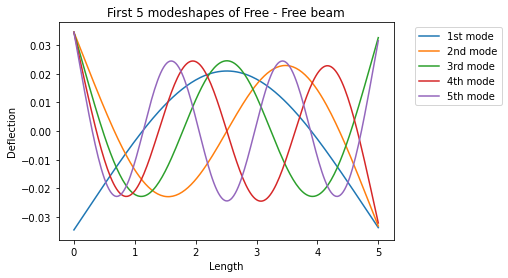

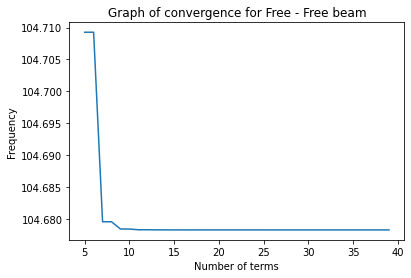

In [16]:
# Free Free
N = 50

# non dimensionalised stiffness matrix
K_MATRIX = make_stiffness_matrix(N)
# make_csv(K_MATRIX, 'K')

# non dimensionalised mass matrix
M_MATRIX = make_mass_matrix(N)
# make_csv(M_MATRIX, 'M')

cM = 0       # Inertial Penalty Parameter
cK = 0       # Stiffness type Penalty Parameter


PenaltyParameter = 1000000
K0 = PenaltyParameter * 0     # Translation at x = 0
KR0 = PenaltyParameter * 0    # Rotation at x = 0
KL = PenaltyParameter * 0     # Translation at x = L
KRL = PenaltyParameter * 0    # Rotation at x = L

TRANSLATIONAL_CONSTRAINT_0 = make_translational_constraint_x_0(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_0, "T_C_0")

ROTATIONAL_CONSTRAINT_0 = make_rotational_constraint_x_0(N)
# make_csv(ROTATIONAL_CONSTRAINT_0, "R_C_0")

TRANSLATIONAL_CONSTRAINT_L = make_translational_constraint_x_L(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_L, "T_C_L")

ROTATIONAL_CONSTRAINT_L = make_rotational_constraint_x_L(N)
# make_csv(ROTATIONAL_CONSTRAINT_L, "R_C_L")



# fnding the penalty matrix of the beam
PENALTY_MATRIX = make_penalty_matrix(TRANSLATIONAL_CONSTRAINT_0, ROTATIONAL_CONSTRAINT_0, TRANSLATIONAL_CONSTRAINT_L,  ROTATIONAL_CONSTRAINT_L, K0, KR0, KL, KRL)
# make_csv(PENALTY_MATRIX, "P_M")


# finding eigen values and eigen vector
evals, evecs = la.eigh(K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX), M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX))
# make_csv(evals, 'evals')
# make_csv(evecs, 'evecs')

# Finding Frequencies
Freq = np.sqrt(evals)


# for plotting
xpoints = 201
N_ELEMENTS = np.linspace(0, LENGTH, xpoints)


PHI = np.zeros((N, xpoints + 1, N))
for p in range(N):
    for q in range(xpoints):
        for r in range(N):
            if r <= 2:
                PHI[p][q][r] = evecs[r][p]*((q/xpoints)**r)
            else:
                PHI[p][q][r] = evecs[r][p]*np.cos(np.pi*(r - 2)*(q/xpoints))


DISP = np.zeros((N, xpoints))
for p in range(N):
    for q in range(xpoints):
        for r in range(N):
            DISP[p][q] = DISP[p][q] + PHI[p][q][r]


#plotting the modeshapes
for p in range(2, 7):
    plt.plot(N_ELEMENTS, DISP[p,:])
    #print(N_ELEMENTS)
plt.legend(['1st mode', '2nd mode', '3rd mode', '4th mode', '5th mode'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("First 5 modeshapes of Free - Free beam")
plt.xlabel("Length")
plt.ylabel("Deflection")
plt.show()
print("==============================================================================")


CONVERGENCE_FRFR = []

for NN in range(5, 40):
# Free - Free

    K_MATRIX = make_stiffness_matrix(NN)
    M_MATRIX = make_mass_matrix(NN)

    TRANSLATIONAL_CONSTRAINT_0 = make_translational_constraint_x_0(NN)
    ROTATIONAL_CONSTRAINT_0 = make_rotational_constraint_x_0(NN)
    TRANSLATIONAL_CONSTRAINT_L = make_translational_constraint_x_L(NN)
    ROTATIONAL_CONSTRAINT_L = make_rotational_constraint_x_L(NN)

    # fnding the penalty matrix of the beam
    PENALTY_MATRIX = make_penalty_matrix(TRANSLATIONAL_CONSTRAINT_0, ROTATIONAL_CONSTRAINT_0, TRANSLATIONAL_CONSTRAINT_L,  ROTATIONAL_CONSTRAINT_L, K0, KR0, KL, KRL)

    # finding eigen values and eigen vector
    evals, evecs = la.eigh(K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX), M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX))
    #make_csv(evals, 'evals')
    #make_csv(evecs, 'evecs')

    # Finding Frequencies
    Freq = np.sqrt(evals)
    CONVERGENCE_FRFR.append(Freq[2]/(2*np.pi))

plt.plot(range(5, 40, 1), CONVERGENCE_FRFR)
plt.title("Graph of convergence for Free - Free beam")
plt.xlabel("Number of terms")
plt.ylabel("Frequency")
plt.ticklabel_format(useOffset=False)
plt.show()


# Modeshapes and Convergence of Fixed - Fixed beam

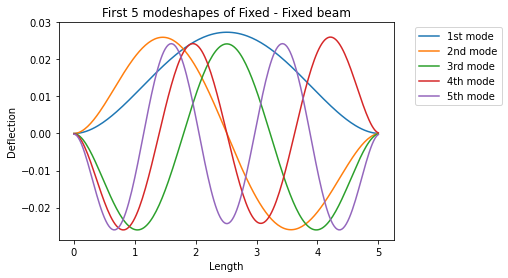

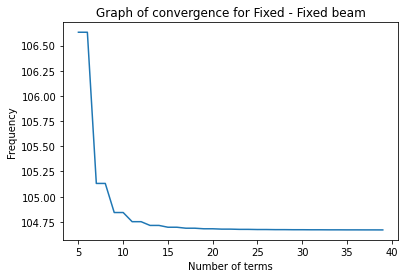

In [17]:
# Fixed - Fixed
N = 50

# non dimensionalised stiffness matrix
K_MATRIX = make_stiffness_matrix(N)
# make_csv(K_MATRIX, 'K')

# non dimensionalised mass matrix
M_MATRIX = make_mass_matrix(N)
# make_csv(M_MATRIX, 'M')

cM = 0       # Inertial Penalty Parameter
cK = 1       # Stiffness type Penalty Parameter

PenaltyParameter = 1000000
K0 = PenaltyParameter * 1     # Translation at x = 0
KR0 = PenaltyParameter * 1    # Rotation at x = 0
KL = PenaltyParameter * 1     # Translation at x = L
KRL = PenaltyParameter * 1    # Rotation at x = L

TRANSLATIONAL_CONSTRAINT_0 = make_translational_constraint_x_0(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_0, "T_C_0")

ROTATIONAL_CONSTRAINT_0 = make_rotational_constraint_x_0(N)
# make_csv(ROTATIONAL_CONSTRAINT_0, "R_C_0")

TRANSLATIONAL_CONSTRAINT_L = make_translational_constraint_x_L(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_L, "T_C_L")

ROTATIONAL_CONSTRAINT_L = make_rotational_constraint_x_L(N)
# make_csv(ROTATIONAL_CONSTRAINT_L, "R_C_L")



# fnding the penalty matrix of the beam
PENALTY_MATRIX = make_penalty_matrix(TRANSLATIONAL_CONSTRAINT_0, ROTATIONAL_CONSTRAINT_0, TRANSLATIONAL_CONSTRAINT_L,  ROTATIONAL_CONSTRAINT_L, K0, KR0, KL, KRL)
# make_csv(PENALTY_MATRIX, "P_M")


# finding eigen values and eigen vector
evals, evecs = la.eigh(K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX), M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX))
# make_csv(evals, 'evals')
# make_csv(evecs, 'evecs')

# Finding Frequencies
Freq = np.sqrt(evals)


# for plotting
xpoints = 201
N_ELEMENTS = np.linspace(0, LENGTH, xpoints)


PHI = np.zeros((N, xpoints + 1, N))
for p in range(N):
    for q in range(xpoints):
        for r in range(N):
            if r <= 2:
                PHI[p][q][r] = evecs[r][p]*((q/xpoints)**r)
            else:
                PHI[p][q][r] = evecs[r][p]*np.cos(np.pi*(r - 2)*(q/xpoints))


DISP = np.zeros((N, xpoints))
for p in range(N):
    for q in range(xpoints):
        for r in range(N):
            DISP[p][q] = DISP[p][q] + PHI[p][q][r]


#plotting the modeshapes
for p in range(0, 5):
    plt.plot(N_ELEMENTS, DISP[p,:])
    #print(N_ELEMENTS)
plt.legend(['1st mode', '2nd mode', '3rd mode', '4th mode', '5th mode'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("First 5 modeshapes of Fixed - Fixed beam")
plt.xlabel("Length")
plt.ylabel("Deflection")
plt.show()
print("==============================================================================")

CONVERGENCE_FIFI = []

for NN in range(5, 40):
# Free - Free

    K_MATRIX = make_stiffness_matrix(NN)
    M_MATRIX = make_mass_matrix(NN)

    TRANSLATIONAL_CONSTRAINT_0 = make_translational_constraint_x_0(NN)
    ROTATIONAL_CONSTRAINT_0 = make_rotational_constraint_x_0(NN)
    TRANSLATIONAL_CONSTRAINT_L = make_translational_constraint_x_L(NN)
    ROTATIONAL_CONSTRAINT_L = make_rotational_constraint_x_L(NN)

    # fnding the penalty matrix of the beam
    PENALTY_MATRIX = make_penalty_matrix(TRANSLATIONAL_CONSTRAINT_0, ROTATIONAL_CONSTRAINT_0, TRANSLATIONAL_CONSTRAINT_L,  ROTATIONAL_CONSTRAINT_L, K0, KR0, KL, KRL)

    # finding eigen values and eigen vector
    evals, evecs = la.eigh(K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX), M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX))
    #make_csv(evals, 'evals')
    #make_csv(evecs, 'evecs')

    # Finding Frequencies
    Freq = np.sqrt(evals)
    CONVERGENCE_FIFI.append(Freq[0]/(2*np.pi))

plt.plot(range(5, 40, 1), CONVERGENCE_FIFI)
plt.title("Graph of convergence for Fixed - Fixed beam")
plt.ticklabel_format(useOffset=False)
plt.xlabel("Number of terms")
plt.ylabel("Frequency")
plt.show()
